## Example use case of Octrac

In [2]:
import s3fs
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
import ocetrac

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

### Import NOAA OISST v2.1 dataset and resample monthly means

In [3]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True, decode_timedelta=True).resample(time='MS').mean()
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 478, zlev: 1)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>


### Feature thresholding

In [4]:
# Compute values of the monthly threshold defined using the 90th percentile

if ds.anom.chunks:
    ds['anom'] = ds.anom.chunk({'time': -1})
    
threshold = ds.groupby(time=month).anom.quantile(.9, dim=('time'))
features_ssta = ds.anom.where(ds.anom>=threshold, other=np.nan).isel(zlev=0)


In [21]:
threshold.shape

(1, 720, 1440)

In [5]:
%%time
features_ssta= features_ssta[:100,:,:].load()

CPU times: user 4min 51s, sys: 1min 12s, total: 6min 4s
Wall time: 5min 24s


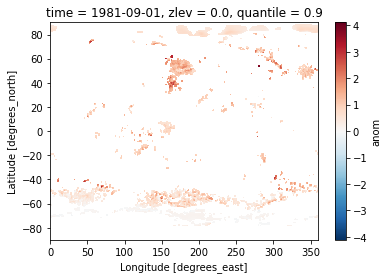

In [7]:
features_ssta.isel(time=0).plot()

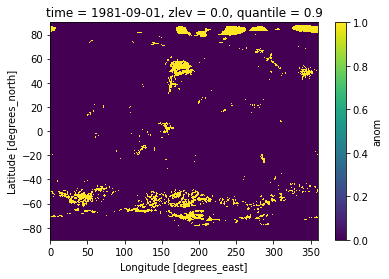

In [9]:
# Binary conversion
binary_out = np.isfinite(features_ssta)
binary_out.isel(time=0).plot()

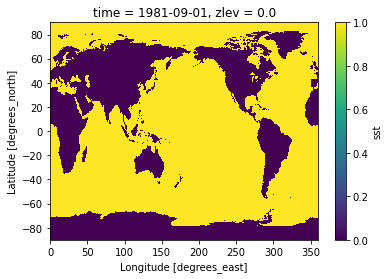

In [14]:
mask = np.isfinite(ds.sst.isel(time=0, zlev=0))
mask.plot()

In [20]:
%%time
Tracker = ocetrac.Tracker(binary_out, mask, radius=8, min_size_quartile=0.75, timedim = 'time', xdim = 'lon', ydim='lat', positive=True)
blobs = Tracker.track()

minimum area: 1845.75
inital objects identified 	 1950
final objects tracked 	 198
CPU times: user 1min 42s, sys: 20.7 s, total: 2min 3s
Wall time: 2min 16s


In [9]:
blobs.attrs

{'inital objects identified': 1901,
 'final objects tracked': 194,
 'radius': 8,
 'size quantile threshold': 0.75,
 'min area': 1901.0,
 'percent area reject': 0.20910629136216072,
 'percent area accept': 0.7908937086378393}

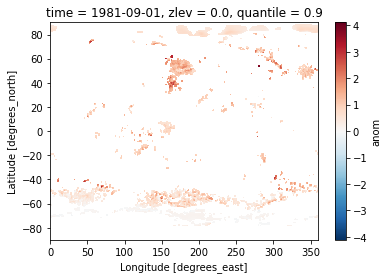

In [17]:
features_ssta.isel(time=0).plot()

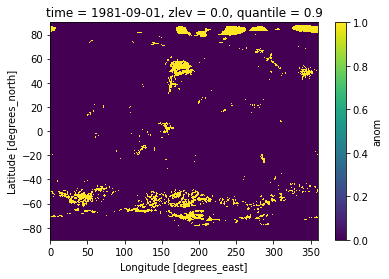

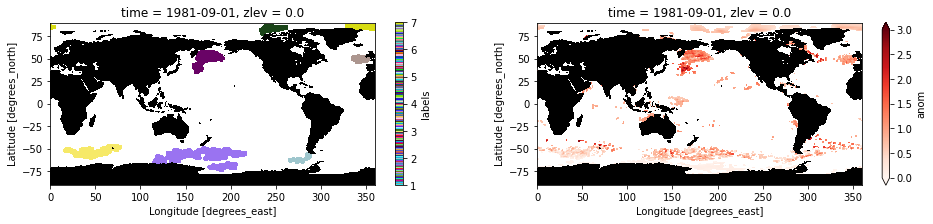

In [10]:
from matplotlib.colors import ListedColormap
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())

plt.figure(figsize=(16,3))
ax1 = plt.subplot(121);blobs.isel(time=0).plot(cmap= cm)
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax1.set_aspect('equal')
ax2 = plt.subplot(122); features_ssta.isel(time=0).plot(cmap='Reds', vmin=0, vmax=3);
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax2.set_aspect('equal');

In [11]:
mo = Tracker._morphological_operations()

In [ ]:
mo.isel(time=0).plot()